FEATURE SELECTION (MRMR,BEA AND KNAPSACK ALGORITHM)

# New Section

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Load your dataset
data = pd.read_csv(r"/content/GSE30208_GPL6102.tsv", sep='\t')

# Assuming the first column is a unique identifier and the last column is the target
features = data.columns[1:-1]
target = data.columns[-1]

# Step 1: Calculate Mutual Information (mRMR)
X = data[features].values
y = data[target].values

# Calculate mutual information scores
mutual_info = mutual_info_classif(X, y)
mutual_info_series = pd.Series(mutual_info, index=features)

# Select top 100 features based on mutual information
selected_features_mRMR = mutual_info_series.nlargest(60).index

# Step 2: Calculate BDSE scores for selected features
feature_variances = data[selected_features_mRMR].var()
bdse_scores = mutual_info_series[selected_features_mRMR] / feature_variances

# Select top 70 features based on BDSE scores
selected_features_BDSE = bdse_scores.nlargest(30).index

# Debugging information for variance and BDSE scores
print("Feature variances (Top 30):", feature_variances[selected_features_BDSE])
print("BDSE scores (Top 30):", bdse_scores[selected_features_BDSE])

# Prepare weights and values for the greedy knapsack
weights = feature_variances[selected_features_BDSE].values
values = bdse_scores[selected_features_BDSE].values
n = len(selected_features_BDSE)

# Set the maximum variance budget to 10% of the total variance of selected features
max_variance_budget = feature_variances[selected_features_BDSE].sum() * 0.1

# Step 3: Implement Greedy Algorithm for Feature Selection
# Calculate value-to-weight ratios
value_to_weight_ratio = values / weights
features_with_ratios = list(zip(selected_features_BDSE, values, weights, value_to_weight_ratio))

# Sort features by value-to-weight ratio in descending order
features_with_ratios.sort(key=lambda x: x[3], reverse=True)

# Select features while respecting the variance budget
selected_features = []
total_weight = 0

for feature, value, weight, _ in features_with_ratios:
    if total_weight + weight <= max_variance_budget:
        selected_features.append(feature)
        total_weight += weight

print("Selected features with greedy approach:", selected_features)


Feature variances (Top 30): M254     374.754641
M16      643.014928
M336     615.721482
M82      875.879720
M232     765.257122
M327     823.765654
M301    1118.950720
M225    1301.472345
M300    1360.962251
M202    1680.796519
M158    1778.440153
M258    2446.427266
M293    2300.121594
M239    4153.242428
M149    3834.865501
M220    4070.028706
M345    7322.954523
M61     3730.123054
M68     4353.802129
M10     4148.183135
M146    8053.912821
M161    6080.939470
M25     5832.858476
M88     4191.734040
M41     5678.699447
M285    4879.175922
M185    6011.861341
M171    5745.329782
M35     5227.221494
M283    7828.399743
dtype: float64
BDSE scores (Top 30): M254    0.000499
M16     0.000259
M336    0.000223
M82     0.000182
M232    0.000180
M327    0.000173
M301    0.000142
M225    0.000106
M300    0.000096
M202    0.000080
M158    0.000075
M258    0.000071
M293    0.000068
M239    0.000051
M149    0.000048
M220    0.000042
M345    0.000041
M61     0.000040
M68     0.000040
M10     0.00

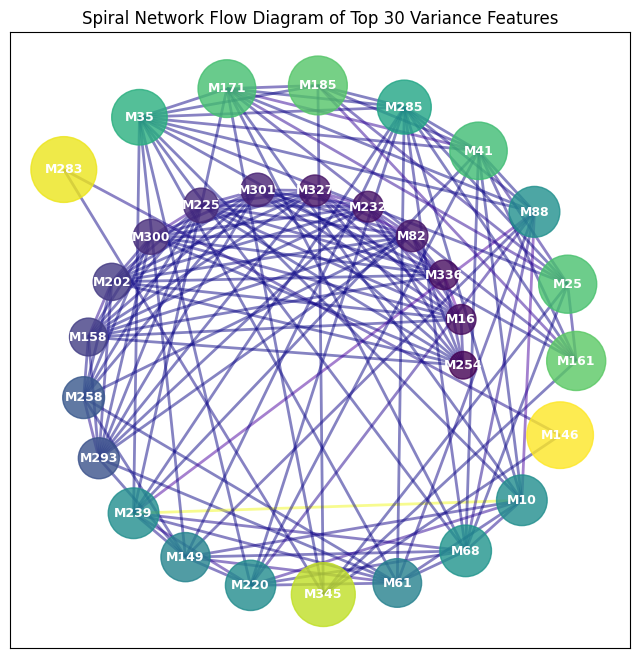

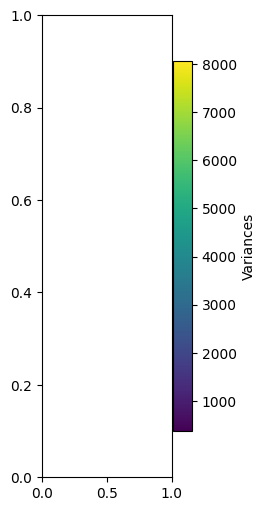

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Function to create a spiral layout for nodes
def spiral_layout(graph, num_nodes):
    pos = {}
    radius = 1.5  # Starting radius
    angle_increment = 0.3  # Angle increment for the spiral effect

    for i, node in enumerate(graph.nodes()):
        angle = i * angle_increment
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        pos[node] = (x, y)
        radius += 0.05  # Gradually increase the radius for the spiral effect
    return pos

# Function to create a colorful spiral network flow diagram for Variance features
def create_variance_spiral_network(features, bdse_scores, variances, title):
    G = nx.Graph()

    # Add nodes with variances as attributes
    for feature in features:
        G.add_node(feature, variance=variances[feature])

    # Threshold for variance similarity
    threshold_variance = 0.2 * variances[features].max()

    # Add edges based on variance similarity
    for i, feature1 in enumerate(features):
        for j, feature2 in enumerate(features):
            if i < j:
                variance_diff = abs(variances[feature1] - variances[feature2])

                if variance_diff < threshold_variance:
                    weight = 1 / (variance_diff + 1e-5)  # Prevent zero division
                    G.add_edge(feature1, feature2, weight=weight)

    # Spiral layout
    pos = spiral_layout(G, len(features))
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # Define color map for nodes based on variance
    node_colors = [variances[feature] for feature in features]
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    node_colors_mapped = [cmap(norm(score)) for score in node_colors]

    # Create figure for the network plot
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    ax1.set_title(title)

    # Draw nodes with color mapping
    node_sizes = [300 + 2000 * variances[feature] / max(node_colors) for feature in features]
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=node_sizes, node_color=node_colors_mapped, alpha=0.8)

    # Draw edges with colors based on similarity weights
    edge_colors = [edge_weights[edge] for edge in G.edges()]
    nx.draw_networkx_edges(G, pos, ax=ax1, edge_color=edge_colors, edge_cmap=plt.cm.plasma, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors), width=2, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=ax1, font_size=9, font_weight='bold', font_color='white')

    # Show network plot
    plt.show(fig1)

    # Create a separate figure for the color bar
    fig2, ax2 = plt.subplots(figsize=(2, 6))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig2.colorbar(sm, ax=ax2, shrink=0.8, pad=0.01)
    cbar.set_label("Variances", fontsize=10)

    # Show color bar
    plt.show(fig2)

# Call function for the top 20 variance features
create_variance_spiral_network(selected_features_BDSE, bdse_scores, feature_variances, "Spiral Network Flow Diagram of Top 30 Variance Features")


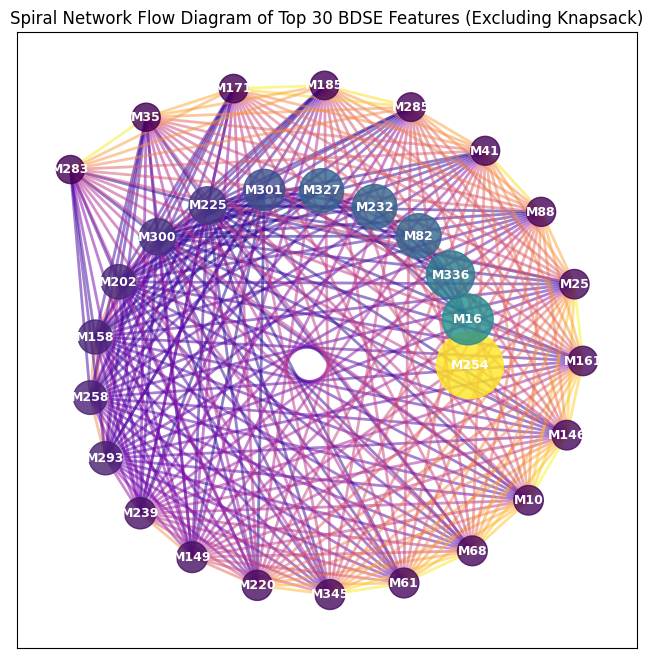

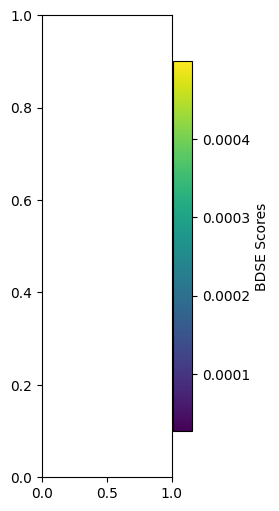

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Function to create a colorful spiral network flow diagram for BDSE features
def create_bdse_spiral_network(features, bdse_scores, variances, title):
    G = nx.Graph()

    # Add nodes with BDSE scores as attributes
    for feature in features:
        G.add_node(feature, bdse_score=bdse_scores[feature])

    # Threshold for BDSE score similarity
    threshold_bdse = 0.2 * bdse_scores[features].max()

    # Add edges based on BDSE similarity
    for i, feature1 in enumerate(features):
        for j, feature2 in enumerate(features):
            if i < j:
                bdse_diff = abs(bdse_scores[feature1] - bdse_scores[feature2])

                if bdse_diff < threshold_bdse:
                    weight = 1 / (bdse_diff + 1e-5)  # Prevent zero division
                    G.add_edge(feature1, feature2, weight=weight)

    # Spiral layout
    pos = spiral_layout(G, len(features))
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # Define color map for nodes based on BDSE scores
    node_colors = [bdse_scores[feature] for feature in features]
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    node_colors_mapped = [cmap(norm(score)) for score in node_colors]

    # Create figure for the network plot
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    ax1.set_title(title)

    # Draw nodes with color mapping
    node_sizes = [300 + 2000 * bdse_scores[feature] / max(node_colors) for feature in features]
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=node_sizes, node_color=node_colors_mapped, alpha=0.8)

    # Draw edges with colors based on similarity weights
    edge_colors = [edge_weights[edge] for edge in G.edges()]
    nx.draw_networkx_edges(G, pos, ax=ax1, edge_color=edge_colors, edge_cmap=plt.cm.plasma, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors), width=2, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=ax1, font_size=9, font_weight='bold', font_color='white')

    # Show network plot
    plt.show(fig1)

    # Create a separate figure for the color bar
    fig2, ax2 = plt.subplots(figsize=(2, 6))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig2.colorbar(sm, ax=ax2, shrink=0.8, pad=0.01)
    cbar.set_label("BDSE Scores", fontsize=10)

    # Show color bar
    plt.show(fig2)

# Call function for the top 20 BDSE features
create_bdse_spiral_network(selected_features_BDSE, bdse_scores, feature_variances, "Spiral Network Flow Diagram of Top 30 BDSE Features (Excluding Knapsack)")


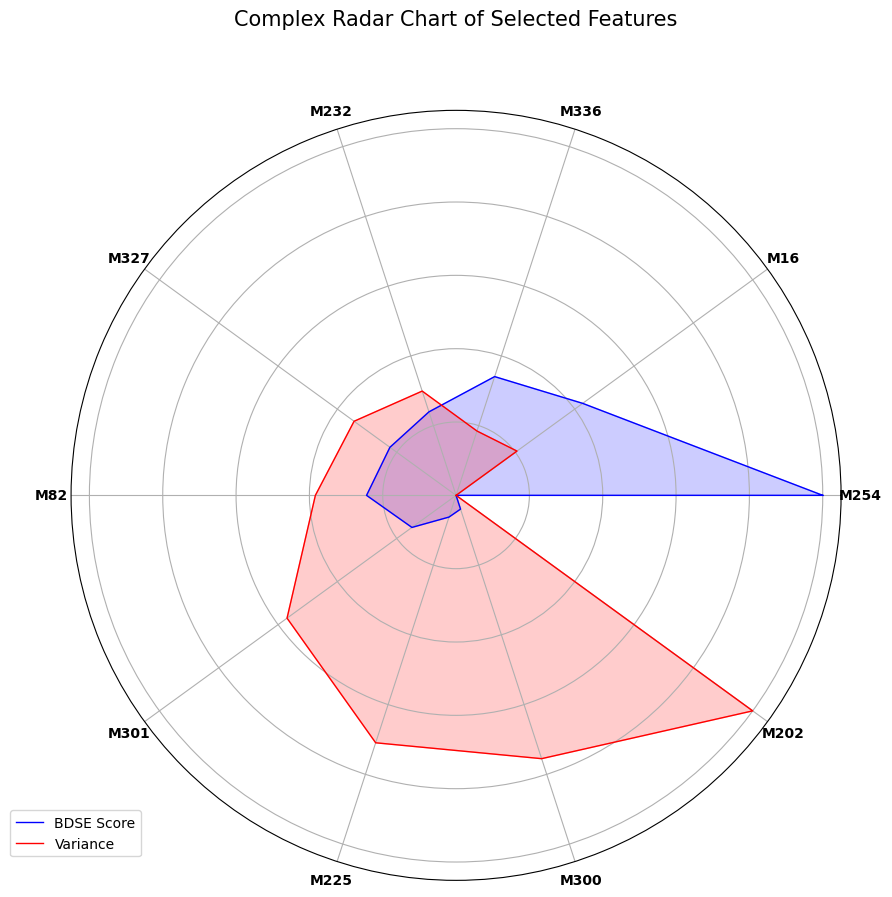

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `selected_features` is a list of features selected by the knapsack algorithm
# `bdse_scores` and `feature_variances` are Series containing BDSE and variance values respectively

def plot_complex_radar_chart(features, bdse_scores, variances):
    """
    Plots a radar chart for selected features with BDSE scores and variances.

    Args:
    - features: list of feature names.
    - bdse_scores: Pandas Series of BDSE scores with feature names as index.
    - variances: Pandas Series of variances with feature names as index.
    """
    num_vars = len(features)

    # Normalizing BDSE scores and variances
    bdse_normalized = (bdse_scores[features] - bdse_scores[features].min()) / (bdse_scores[features].max() - bdse_scores[features].min())
    var_normalized = (variances[features] - variances[features].min()) / (variances[features].max() - variances[features].min())

    # Setting up the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Completing the loop

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Plotting BDSE scores
    bdse_values = bdse_normalized.values.tolist()
    bdse_values += bdse_values[:1]
    ax.plot(angles, bdse_values, linewidth=1, linestyle='solid', label="BDSE Score", color='blue')
    ax.fill(angles, bdse_values, color='blue', alpha=0.2)

    # Plotting Variance values
    var_values = var_normalized.values.tolist()
    var_values += var_values[:1]
    ax.plot(angles, var_values, linewidth=1, linestyle='solid', label="Variance", color='red')
    ax.fill(angles, var_values, color='red', alpha=0.2)

    # Adding feature names
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=10, fontweight='bold', rotation=45)

    # Adding custom labels for the axes
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_yticklabels([])  # Hiding the y-axis labels for cleaner look

    # Adding Legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Title
    plt.title("Complex Radar Chart of Selected Features", size=15, color='black', y=1.1)
    plt.show()

# Run the radar chart plot
if selected_features:
    plot_complex_radar_chart(selected_features, bdse_scores, feature_variances)
else:
    print("No features selected. Please adjust max_variance_budget or check feature selection output.")


SVM




In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "/content/GSE30208_GPL6102.tsv"  # Update this path as needed
data = pd.read_csv(file_path, sep='\t')

selected_biomarkers=['M254',
'M16',
'M336',
'M82',
'M232',
'M327',
'M301',
'M225',
'M300',
'M202',
'M158',
'M258',
'M293',
'M239',
'M149',
'M220',
'M345',
'M61',
'M68',
'M10',
'M146',
'M161',
'M25',
'M88',
'M41',
'M285',
'M185',
'M171',
'M35',
'M283',]

# Filter the dataset to include only the selected biomarkers and the PhenoType column
filtered_data = data[selected_biomarkers + ["PhenoType"]].copy()

# Encode 'PhenoType' as binary (Case=1, Control=0)
filtered_data['PhenoType'] = filtered_data['PhenoType'].apply(lambda x: 1 if x == 'Case' else 0)

# Separate features and target
X = filtered_data[selected_biomarkers]
y = filtered_data['PhenoType']

# Standardize the features (important for models like SVM)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train models
models = {
    'SVM': SVC(kernel='linear', random_state=42),
}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    predictions = model.predict(X_test)

    # Generate and display classification report
    report = classification_report(y_test, predictions, target_names=['Control', 'Case'])
    print(f"{model_name} Classification Report:\n{report}\n")


SVM Classification Report:
              precision    recall  f1-score   support

     Control       1.00      0.89      0.94         9
        Case       0.91      1.00      0.95        10

    accuracy                           0.95        19
   macro avg       0.95      0.94      0.95        19
weighted avg       0.95      0.95      0.95        19




In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu, ttest_ind, shapiro

# Load dataset
file_path = '/content/GSE30208_GPL6102.tsv'
data = pd.read_csv(file_path, sep='\t')

# Selected biomarkers
selected_biomarkers = [
    'M254', 'M16', 'M336', 'M82', 'M232', 'M327', 'M301', 'M225', 'M300', 'M202',
    'M158', 'M258', 'M293', 'M239', 'M149', 'M220', 'M345', 'M61', 'M68', 'M10',
    'M146', 'M161', 'M25', 'M88', 'M41', 'M285', 'M185', 'M171', 'M35', 'M283'
]

# Significance threshold
alpha = 0.05

# Split data into case and control
case_data = data[data['PhenoType'] == 'Case']
control_data = data[data['PhenoType'] == 'Control']

# Perform statistical tests
results = []

for biomarker in selected_biomarkers:
    case_values = case_data[biomarker].dropna().values
    control_values = control_data[biomarker].dropna().values

    # Check if there's enough data
    if len(case_values) < 3 or len(control_values) < 3:
        results.append({
            'Biomarker': biomarker,
            'Test Used': 'Insufficient Data',
            'P-Value': None,
            'Statistically Significant': False
        })
        continue

    # Check normality using Shapiro-Wilk test
    case_normal = shapiro(case_values).pvalue > alpha
    control_normal = shapiro(control_values).pvalue > alpha

    # Choose appropriate test based on normality
    if case_normal and control_normal:
        # Use t-test if both groups are normally distributed
        t_stat, p_value = ttest_ind(case_values, control_values)
        test_used = 't-test'
    else:
        # Use Mann-Whitney U test otherwise
        _, p_value = mannwhitneyu(case_values, control_values, alternative='two-sided')
        test_used = 'Mann-Whitney U'

    # Append results
    results.append({
        'Biomarker': biomarker,
        'Test Used': test_used,
        'P-Value': p_value,
        'Statistically Significant': p_value < alpha
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='P-Value', inplace=True)  # Sort by p-value for easier analysis

# Display the results
results_df


,Biomarker,Test Used,P-Value,Statistically Significant
20,M146,t-test,3.450162e-08,True
13,M239,t-test,9.634600e-07,True
16,M345,t-test,1.195830e-06,True
24,M41,Mann-Whitney U,3.450598e-06,True
8,M300,t-test,5.063615e-06,True
29,M283,t-test,5.305646e-06,True
18,M68,t-test,6.342743e-06,True
21,M161,t-test,1.211626e-05,True
17,M61,Mann-Whitney U,2.562671e-05,True
11,M258,t-test,1.037769e-04,True


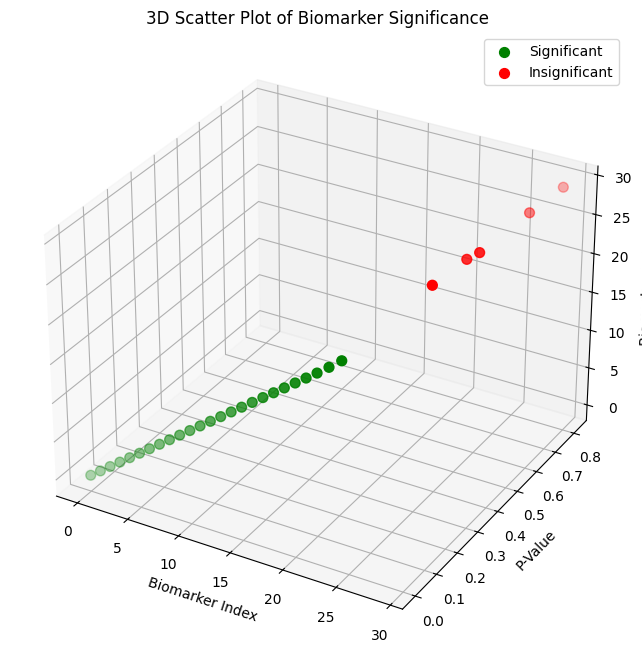

In [ ]:
# prompt: can u plot a 3D graph on the same can u use gree for significant and red for insignificant

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_significance(results_df):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Prepare data for plotting
    biomarkers = results_df['Biomarker']
    p_values = results_df['P-Value']
    significance = results_df['Statistically Significant']

    x = np.arange(len(biomarkers))
    y = p_values
    z = x

    # Separate significant and insignificant points
    significant_x = x[significance]
    significant_y = y[significance]
    significant_z = z[significance]

    insignificant_x = x[~significance]
    insignificant_y = y[~significance]
    insignificant_z = z[~significance]

    # Plot significant points in green
    ax.scatter(significant_x, significant_y, significant_z, c='green', label='Significant', s=50)

    # Plot insignificant points in red
    ax.scatter(insignificant_x, insignificant_y, insignificant_z, c='red', label='Insignificant', s=50)

    # Set labels and title
    ax.set_xlabel('Biomarker Index')
    ax.set_ylabel('P-Value')
    ax.set_zlabel('Biomarker Index')
    ax.set_title('3D Scatter Plot of Biomarker Significance')
    ax.legend()

    plt.show()

# Assuming 'results_df' is available from the previous code
plot_3d_significance(results_df)

NameError: name 'models' is not defined